#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

For task 1.1 see the corresponding Notebook in [Task 1.1 - Data Understanding](Task1_Data_Understanding.ipynb).

For this task we followed the following check structure: [#WIP]()
1. Data aggregation
2. Reduction of dimensionality
3. Data cleaning
4. Discretization
5. Data transformation
6. Principal Component Analysis via Covariance Matrix
8. Data Similarity via Entropy and proximity coefficients


In [20]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import entropy
import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)

# Load dataset from data understanding
#df_incident_du = pd.read_csv('../ds/cleaned/incidents_cleaned.csv')
df = pd.read_hdf('../ds/cleaned/incidents_cleaned.h5', key = 'df')
df_incident_du = df.copy()   
df_poverty_du = pd.read_csv('../ds/cleaned/poverty_cleaned.csv')
df_years_state_du = pd.read_csv('../ds/cleaned/year_state_votes_cleaned.csv')


In [21]:
# Check if dataset loaded correctly
df_incident_du.head()
#df_poverty_du.head()
#df_years_state_du.head()

#df_incident_du.info()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year
218445,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014
180520,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,28,Adult 18+,Male,28,28,0,0,0,0,2,0,0,2,Shot - Wounded/Injured,2014
44077,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,35,Adult 18+,Female,35,35,0,0,2,0,1,0,1,2,other,2014
89936,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,28,Adult 18+,Male,28,30,0,0,1,0,3,0,0,3,Shot - Wounded/Injured,2014
186445,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,47,Adult 18+,Male,47,47,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",2014


### Fix little problem with reimporting datasets

CSV files do not store informations about categories and datatypes like the one we saved.

# Joining the datasets

We have three dataset: the one with the incidents, one with poverty by state (just two columns) and one with year, state and how much votes each party got. We want to join the three datasets in order to have a single dataset with all the information we need. 

In [22]:
# We need to do merge function from pandas

df_merged_incident_poverty = pd.merge(df_incident_du ,df_poverty_du, on=['year', 'state'], how='left')

df_merged_incident_poverty.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,28,Adult 18+,Male,28,28,0,0,0,0,2,0,0,2,Shot - Wounded/Injured,2014,14.5
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,35,Adult 18+,Female,35,35,0,0,2,0,1,0,1,2,other,2014,10.1
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,28,Adult 18+,Male,28,30,0,0,1,0,3,0,0,3,Shot - Wounded/Injured,2014,13.4
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,47,Adult 18+,Male,47,47,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",2014,10.2



# Idea: Let's try to get number of incidents every 3 months
## Maybe this in data preparation
Since 2018 is the year with less records we could try to visualize what period contains more incidents, let's try to monitor every 3 months:

# How many injured and killed people have been involved w.r.t the total injured and killed people in the same STATE during 2016 - 2018

In [23]:

desired_years = [2016, 2017, 2018]
df_filtered = df_merged_incident_poverty[df_merged_incident_poverty['year'].isin(desired_years)]
# Group by congressional district
grouped_district = df_filtered.groupby('state')

#number of injured for each district
total_injured_district = df_merged_incident_poverty.groupby('state')['n_injured'].sum().reset_index()

#number of killed for each district
total_killed_district = df_merged_incident_poverty.groupby('state')['n_killed'].sum().reset_index()

# Calculate the total number of killed and injured people for each district
total_killed_injured = grouped_district[['n_killed', 'n_injured']].sum().reset_index()

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_injured'] = (total_killed_injured['n_injured'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100
# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_killed'] = (total_killed_injured['n_killed'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100
# Display the resulting DataFrame
print(total_killed_injured)


                   state  n_killed  n_injured  percentage_injured  \
0                Alabama       950        690           42.073171   
1                 Alaska       130         89           40.639269   
2                Arizona       485        279           36.518325   
3               Arkansas       361        515           58.789954   
4             California      2146       1778           45.310907   
5               Colorado       327        249           43.229167   
6            Connecticut       152        342           69.230769   
7               Delaware        93        383           80.462185   
8   District of Columbia       181        137           43.081761   
9                Florida      1698       1976           53.783342   
10               Georgia       980       1088           52.611219   
11                Hawaii        37         34           47.887324   
12                 Idaho        77         55           41.666667   
13              Illinois      1669

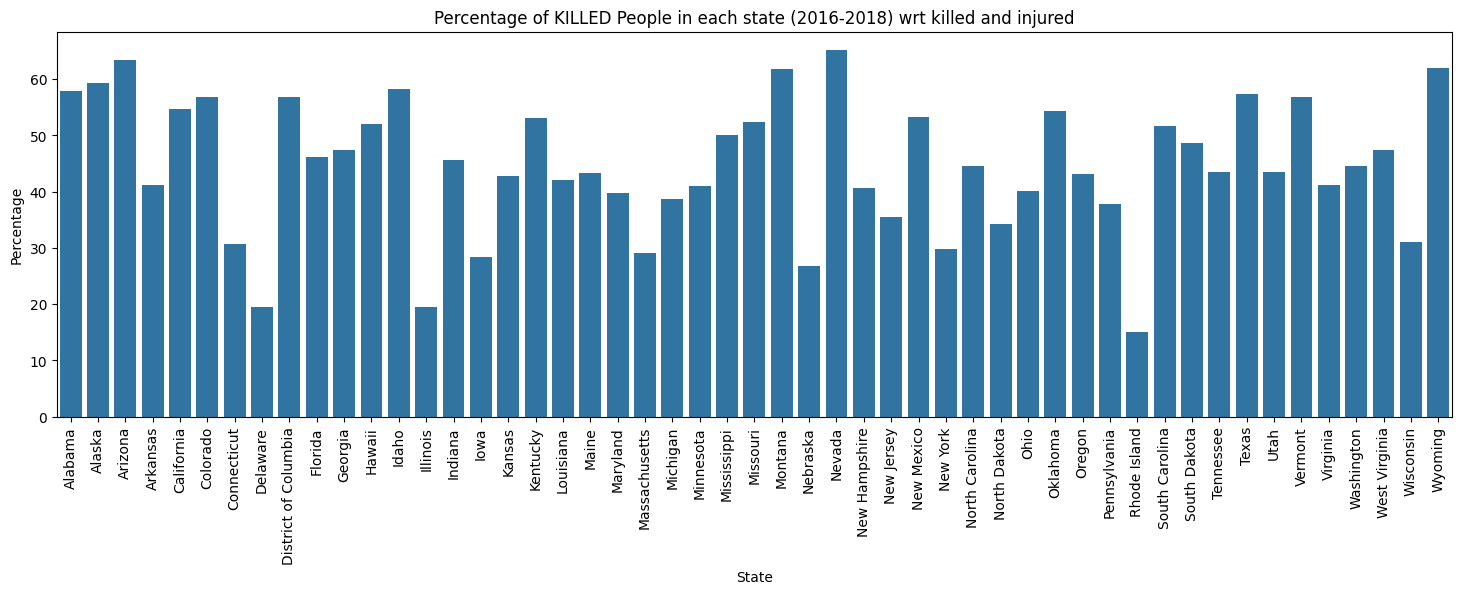

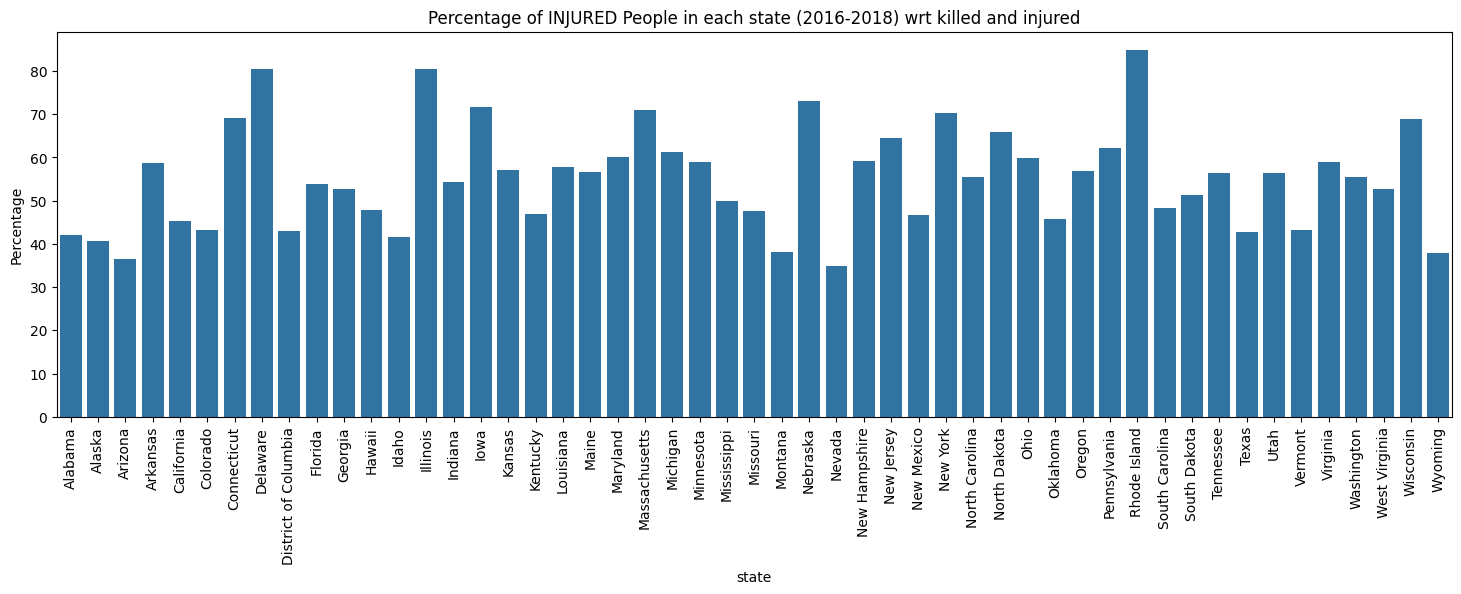

In [24]:

# Plot for percentage of killed people
plt.figure(figsize=(18, 5))
sns.barplot(x='state', y='percentage_killed', data=total_killed_injured)
plt.title('Percentage of KILLED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

# Plot for percentage of injured people
plt.figure(figsize=(18, 5))
sns.barplot(x='state', y='percentage_injured', data=total_killed_injured)
plt.title('Percentage of INJURED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('state')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

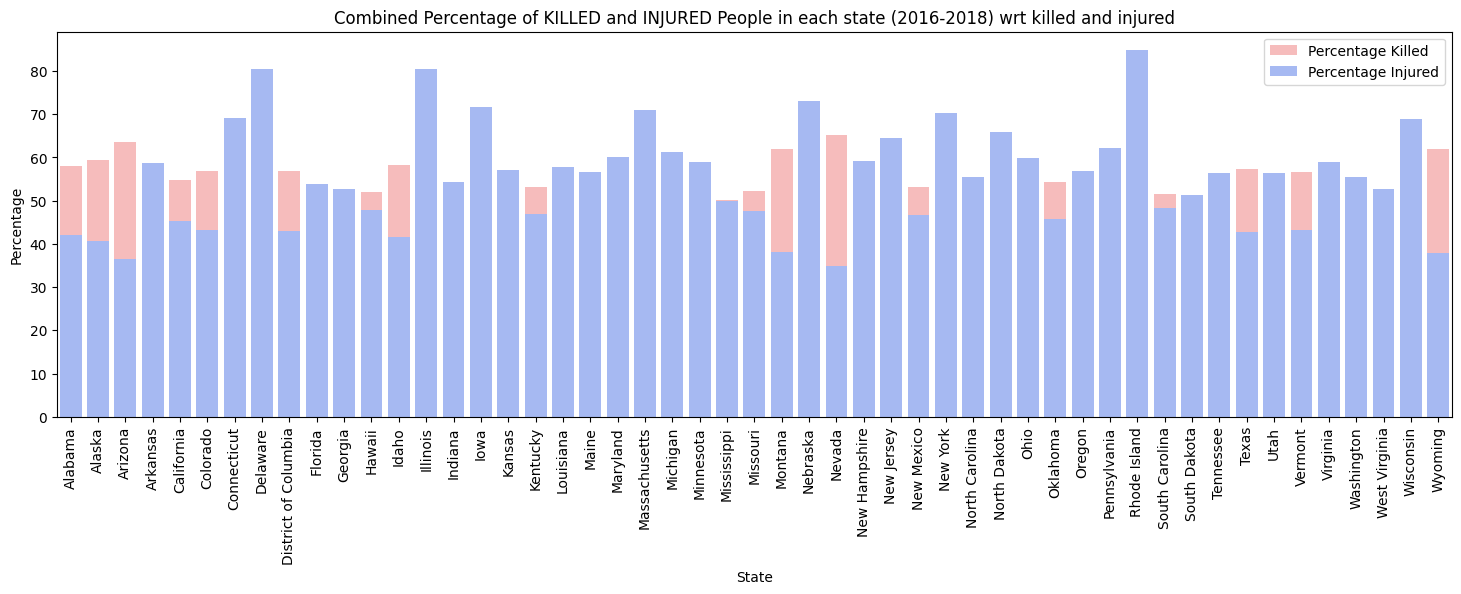

In [25]:
# Plot for combined percentage of killed and injured people
plt.figure(figsize=(18, 5))

# Plotting killed percentage
sns.barplot(x='state', y='percentage_killed', data=total_killed_injured, color='#ffb3b3', label='Percentage Killed')

# Plotting injured percentage
sns.barplot(x='state', y='percentage_injured', data=total_killed_injured, color='#99b3ff', label='Percentage Injured')

plt.title('Combined Percentage of KILLED and INJURED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.legend()

plt.show()

# Incidents - Year - Poverty

In [26]:
df_merged_incident_poverty.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,26,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,28,Adult 18+,Male,28,28,0,0,0,0,2,0,0,2,Shot - Wounded/Injured,2014,14.5
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,35,Adult 18+,Female,35,35,0,0,2,0,1,0,1,2,other,2014,10.1
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,28,Adult 18+,Male,28,30,0,0,1,0,3,0,0,3,Shot - Wounded/Injured,2014,13.4
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,47,Adult 18+,Male,47,47,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",2014,10.2


In [27]:
spearman_corr = df_merged_incident_poverty[['n_participants', 'povertyPercentage']].corr(method='spearman').iloc[0, 1]
print(spearman_corr)

0.1244585209441859


   year  povertyPercentage
0  2014          13.850831
1  2015          12.887349
2  2016          12.363970
3  2017          11.651844
4  2018          11.392776


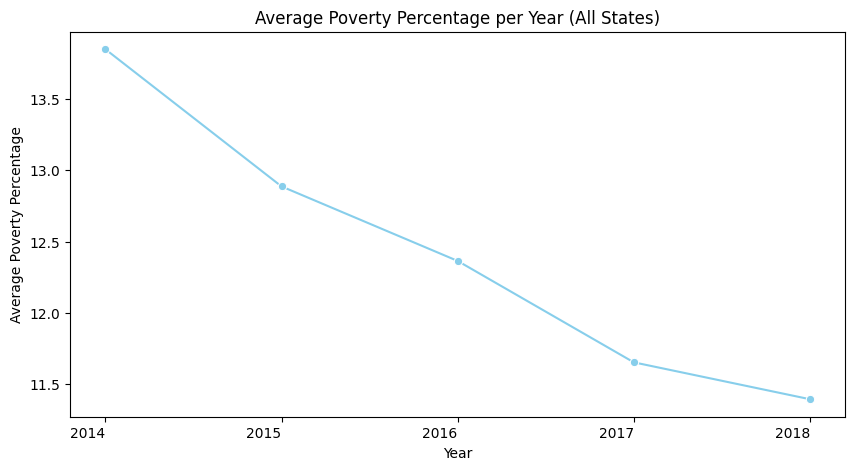

In [28]:
# Calculate the median of 'povertyPercentage' for each year
avg_poverty_per_year = df_merged_incident_poverty.groupby('year')['povertyPercentage'].mean().reset_index()

# Visualizza i risultati
print(avg_poverty_per_year)

# Line plot of the average 'povertyPercentage' for all states over the years
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_poverty_per_year, x='year', y='povertyPercentage', marker='o', color='skyblue')
plt.title('Average Poverty Percentage per Year (All States)')
plt.xlabel('Year')
plt.ylabel('Average Poverty Percentage')
plt.xticks(avg_poverty_per_year['year'].unique(), rotation=0, ha='right')  # Adatta il valore 'rotation' come preferisci
plt.show()

<Axes: >

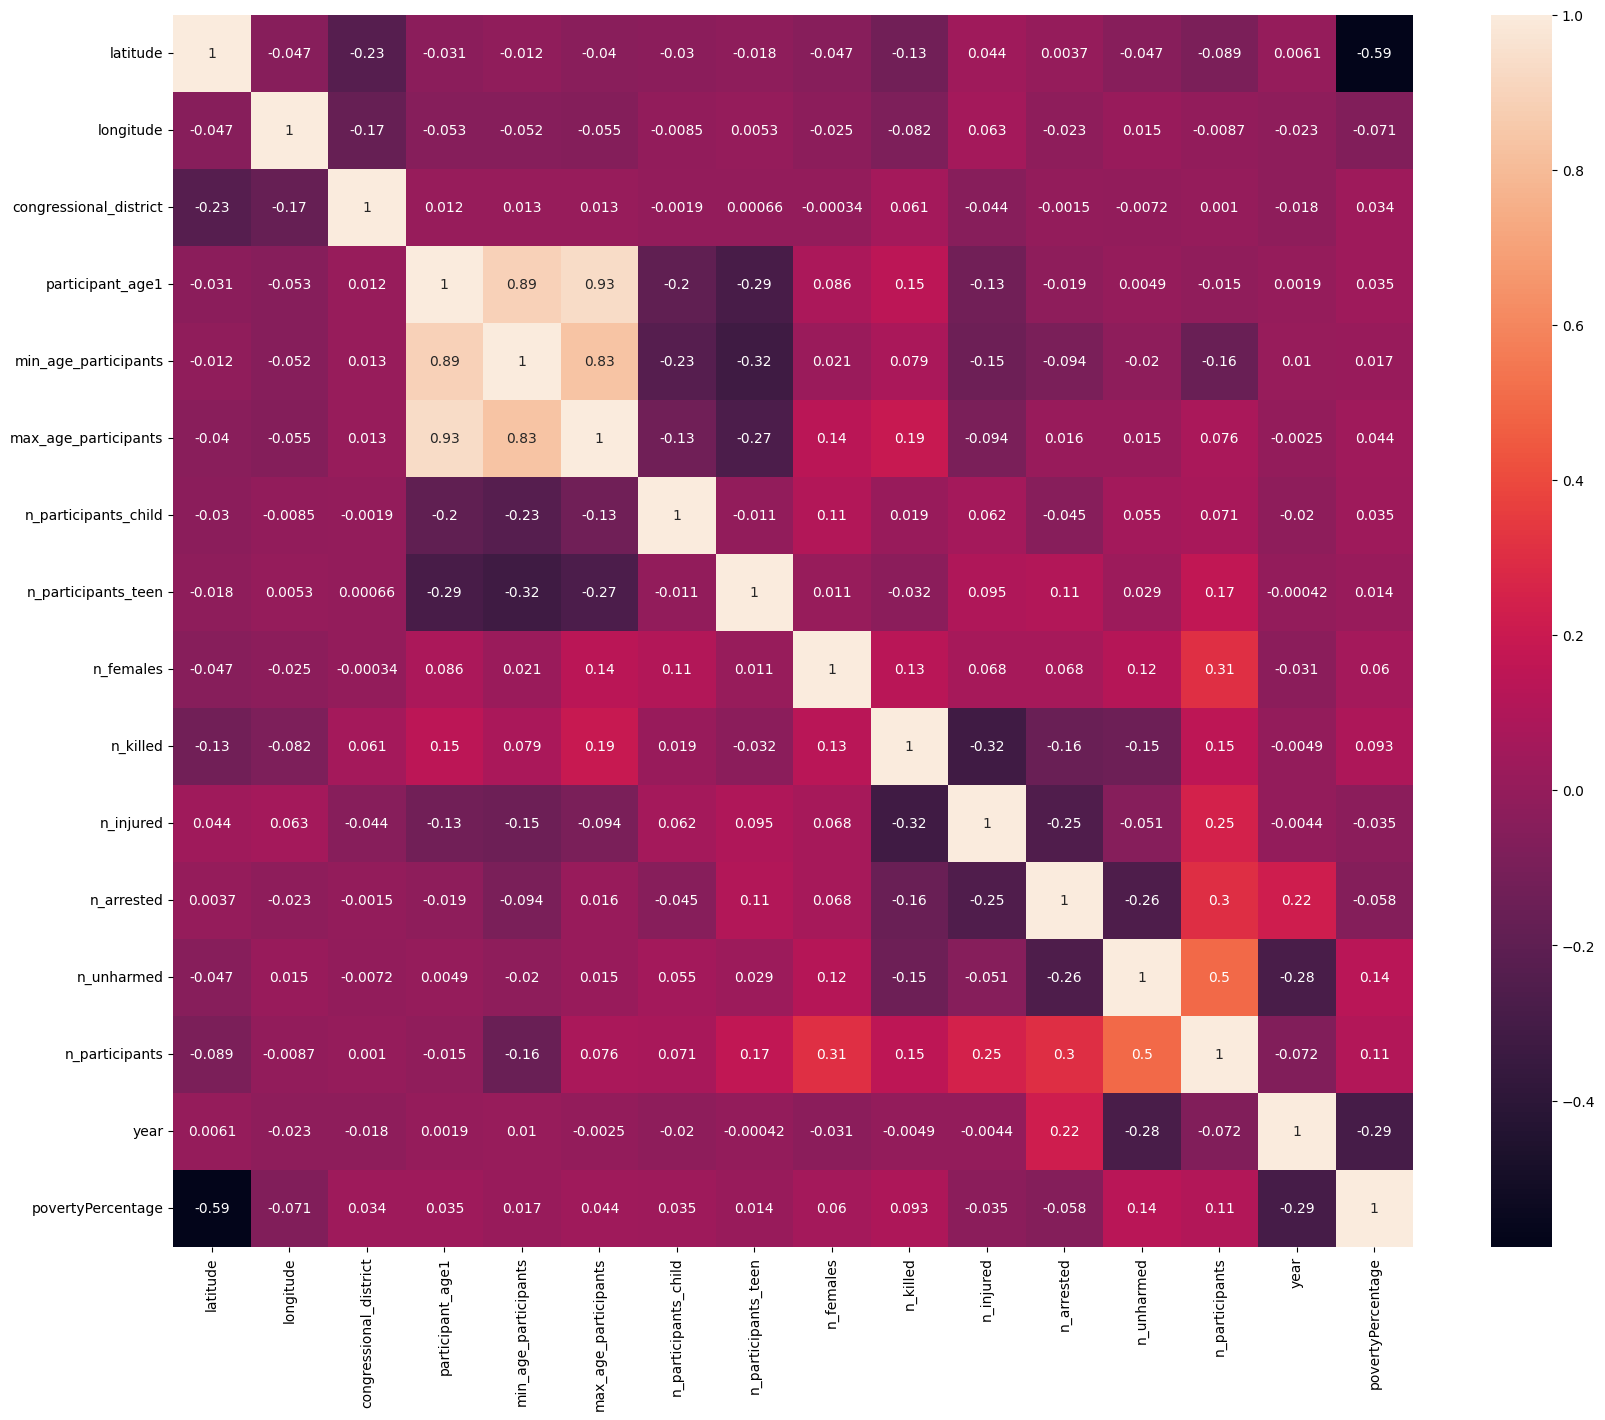

In [29]:
numerical_features_corr_mat = df_merged_incident_poverty.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 16))  # Adjust the values (width, height) as needed
corr_matrix_df_merged = df_merged_incident_poverty[numerical_features_corr_mat].corr()
sns.heatmap(corr_matrix_df_merged, annot=True)

In [31]:

from scipy.stats import entropy
# Calcola l'entropia per la colonna 'target'
target_entropy = entropy(df_merged_incident_poverty['povertyPercentage'].value_counts(), base=2)
print(f'Entropy of target column: {target_entropy}')


Entropy of target column: 6.060132203440956


In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Seleziona le colonne di interesse per il clustering
features = df_merged_incident_poverty[['latitude', 'longitude', 'n_killed', 'n_injured', 'povertyPercentage']]

# Standardizza le features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Applica l'algoritmo K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_merged_incident_poverty['povertyPercentage'] = kmeans.fit_predict(features_scaled)

/home/af/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

